In [1]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools

# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

# !apt-get update -qq 2>&1 > /dev/null

# !apt-get -y install -qq google-drive-ocamlfuse fuse


# from google.colab import auth

# auth.authenticate_user()


# from oauth2client.client import GoogleCredentials

# creds = GoogleCredentials.get_application_default()

# import getpass

# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

# vcode = getpass.getpass()

# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# !mkdir -p drive

# !google-drive-ocamlfuse drive

In [2]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

In [3]:
def load_data(): # load dataset from breast cancer file
    samples = []
    labels = []
    # with open('drive/MyColab/magic04_data.csv', 'r') as csvfile:
    with open('breastcancer_data.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[1] == 'M': labels.append(1)
            else: labels.append(0)

            samples.append([float(i) for i in row[2:]])
    samples, labels = np.array(samples), np.array(labels).reshape(-1, 1) # prevent returning a ranked-1-array
    samples = (samples - np.mean(samples, axis=1).reshape(-1, 1))/np.std(samples, axis=1).reshape(-1, 1)

    return samples, labels

In [4]:
def initialize_parameters(n_input, n_hidden): # initialize parameters with tiny random numbers
    num_of_layers = len(n_hidden)
    parameters = {}
    
    parameters['w1'] = np.random.randn(n_hidden[0], n_input)
    parameters['b1'] = np.random.randn(n_hidden[0], 1)
    
    for i in range(1, num_of_layers):
        parameters['w'+str(i+1)] = np.random.randn(n_hidden[i], n_hidden[i-1])
        parameters['b'+str(i+1)] = np.random.randn(n_hidden[i], 1)
    
    parameters['w'+str(num_of_layers+1)] = np.random.randn(1, n_hidden[num_of_layers-1])
    parameters['b'+str(num_of_layers+1)] = np.random.randn(1, 1)

    return parameters

In [5]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def relu(z):
    z_temp = z.copy()
    z_temp[z < 0] = 0
    return z_temp

def relu_derivative(z):
    z_temp = np.zeros(z.shape)
    z_temp[z >= 0] = 1
    return z_temp

In [6]:
def forward_prop(x, parameters, activation):
    cache = {}
    last_neuron = len(parameters) // 2
    cache['a'+str(0)] = x
    
    for l in range(1, last_neuron+1):
        cache['z'+str(l)] = np.dot(parameters['w'+str(l)], cache['a'+str(l-1)]) + parameters['b'+str(l)]
        if l == last_neuron: cache['a'+str(last_neuron)] = sigmoid(cache['z'+str(last_neuron)])
        elif activation == 'relu': cache['a'+str(l)] = relu(cache['z'+str(l)])
        elif activation == 'sigmoid': cache['a'+str(l)] = sigmoid(cache['z'+str(l)])
        elif activation == 'tanh': cache['a'+str(l)] = np.tanh(cache['z'+str(l)])
        
#     cache['z'+str(last_neuron)] = np.dot(parameters['w'+str(last_neuron)], cache['a'+str(last_neuron-1)]) + parameters['b'+str(last_neuron)]
#     cache['a'+str(last_neuron)] = sigmoid(cache['z'+str(last_neuron)])

    return cache

In [7]:
def back_prop(x, y, cache, parameters, activation):
    m = x.shape[1]
    gradients = {}
    last_neuron = len(parameters) // 2
    
#     A = cache['a' + str(last_neuron)]
#     gradients['da'+str(last_neuron)] = -(np.divide(y, A) - np.divide(1-y, 1-A))
#     gradients['dz' + str(last_neuron)] = gradients['da' + str(last_neuron)] * (sigmoid(cache['z'+str(last_neuron)])*(1 - sigmoid(cache['z'+str(last_neuron)])))
    gradients['dz'+str(last_neuron)] = cache['a'+str(last_neuron)] - y.T
    gradients['dw'+str(last_neuron)] = 1/m * np.dot(gradients['dz'+str(last_neuron)], cache['a'+str(last_neuron-1)].T)
    gradients['db'+str(last_neuron)] = 1/m * np.sum(gradients['dz'+str(last_neuron)], axis=1, keepdims=True)
        
    for i in reversed(range(1, last_neuron)):
        if activation == 'sigmoid': gradients['dz'+str(i)] = np.dot(parameters['w'+str(i+1)].T, 
                                                                    gradients['dz'+str(i+1)]) * (sigmoid(cache['z'+str(i)])*(1 - sigmoid(cache['z'+str(i)])))
        elif activation == 'relu': gradients['dz'+str(i)] = np.dot(parameters['w'+str(i+1)].T, 
                                                                   gradients['dz'+str(i+1)]) * relu_derivative(cache['z'+str(i)])
        elif activation == 'tanh': gradients['dz'+str(i)] = np.dot(parameters['w'+str(i+1)].T, 
                                                                   gradients['dz'+str(i+1)]) * (1 - np.power(np.tanh(cache['z'+str(i)]), 2))
        gradients['dw'+str(i)] = 1/m * np.dot(gradients['dz'+str(i)], cache['a'+str(i-1)].T)
        gradients['db'+str(i)] = 1/m * np.sum(gradients['dz'+str(i)], axis=1, keepdims=True)
    
    return gradients

In [8]:
def cost_function(m, labels, y_hat):
    logprobs = np.sum(labels * np.log(y_hat)) + np.sum((1-labels) * np.log(1 - y_hat))
    return -1/m * logprobs

In [9]:
def multi_Layered_NN(samples, labels, activation, n_hidden, num_iterations, learning_rate, print_cost=False):
    m = samples.shape[1]
    params = initialize_parameters(samples.shape[0], n_hidden)
    cost_history = []
    last_neuron = len(params) // 2
    
    for i in range(num_iterations+1):
        cache = forward_prop(samples, params, activation)
        
        cost = cost_function(m, labels, cache['a'+str(last_neuron)].T)
        
        gradients = back_prop(samples, labels, cache, params, activation)
        for j in range(1, last_neuron+1):
            params['w'+str(j)] -= learning_rate * gradients['dw'+str(j)]
            params['b'+str(j)] -= learning_rate * gradients['db'+str(j)]

        if print_cost and i%1000 == 0: 
            print('cost after epoch {}: {}'.format(int(i/1000), cost))
            cost_history.append(cost)

    return {'parameters':params, 
            'cache': cache,
            'cost_history':cost_history
           }


In [10]:
def predict(x, parameters, activation):
    last_neuron = len(parameters) // 2
    cache = forward_prop(x.T, parameters, activation)
    y_hat = cache['a'+str(last_neuron)]
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    return y_hat.T

In [11]:
# samples, labels = load_data()
from sklearn.datasets import load_breast_cancer
samples, labels = load_breast_cancer(return_X_y=True)
labels = labels.reshape(-1, 1)

samples = (samples - np.mean(samples, axis=1).reshape(-1, 1))/(np.max(samples, axis=1).reshape(-1, 1) - np.min(samples, axis=1).reshape(-1, 1))
# samples = (samples - np.mean(samples, axis=1).reshape(-1, 1))/(np.std(samples, axis=1)).reshape(-1, 1)

# samples_sparse = coo_matrix(samples)
# samples, samples_sparse, labels = shuffle(samples, samples_sparse, labels)

train_data, test_data, train_label, test_label = train_test_split(samples, labels, test_size=0.25, random_state=4)

In [14]:
model = multi_Layered_NN(train_data.T, train_label, activation='tanh', n_hidden=[100, 100, 100], num_iterations=7000, learning_rate=0.001, print_cost=True)
pred_labels = predict(train_data, parameters=model['parameters'], activation='tanh')
print('accuracy on train set:', (np.sum(pred_labels == train_label)/pred_labels.size) * 100, '%')
pred_labels = predict(test_data, parameters=model['parameters'], activation='tanh')
print('accuracy on test set:', (np.sum(pred_labels == test_label)/pred_labels.size) * 100, '%')

cost after epoch 0: 2.780746665694302
cost after epoch 1: 0.1752110307933066
cost after epoch 2: 0.14852927534874197
cost after epoch 3: 0.14110232380998755
cost after epoch 4: 0.13688123346852327
cost after epoch 5: 0.1336673713412173
cost after epoch 6: 0.13110329007342478
cost after epoch 7: 0.12897798500200103
accuracy on train set: 95.07042253521126 %
accuracy on test set: 87.41258741258741 %


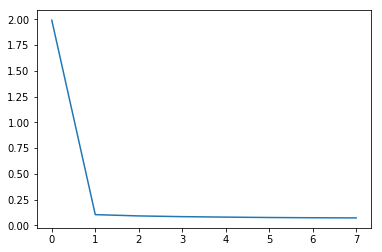

In [208]:
import matplotlib.pyplot as plt

plt.plot(range(len(model['cost_history'])), model['cost_history'])
plt.show()

In [185]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(5,5,3), activation='relu', solver='sgd', alpha=0, learning_rate_init=0.001, max_iter=7000)
clf.fit(train_data, train_label)

print('accuracy on train set:', clf.score(train_data, train_label)*100)
print('accuracy on test set:', clf.score(test_data, test_label)*100)
print('loss:', clf.loss_)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy on train set: 61.502347417840376
accuracy on test set: 66.43356643356644
loss: 0.6728075176386961


In [111]:
960.9234168678619 / 0.670938401712149

1432.2081049701555